In [83]:
#https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
#cool code for a button to hide code 
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tabulate
import statistical_tools as s_tools
import statsmodels.api as sm 
from statsmodels.formula.api import glm 
#plotting with seaborn
#https://cmdlinetips.com/2019/02/how-to-make-histogram-in-python-with-pandas-and-seaborn/

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

This time we want to play around with some of the other factors a bit more, now last time I fixed up the missing values in Age, but I just wanted to show the nice technique visually for how to fill in some of this numerical data.

In [61]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

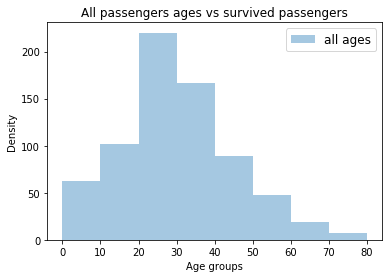

In [62]:
 def plot_distr(df):
    max_age = max(df['Age'])
    bin_count = np.linspace(0, max_age, (int(max_age/10)+1))
    sns.distplot(df['Age'], bins=bin_count, kde=False, label='all ages');

    plt.legend(prop={'size': 12});
    plt.title('All passengers ages vs survived passengers');
    plt.xlabel('Age groups');
    plt.ylabel('Density');
plot_distr(train)

This is a distribution plot of the ages, and we have lots of NA values, so we need to fill in the gaps somehow. We could replace them with the mean or median, but this would narrow the distirbution and alter the data. What we will actually do is randomly sample from this dataset within our usually expected range within a std's either side of the mean

In [63]:
#replace null values with random samples from distr
def resample_age_values(df):
    mean = np.mean(df['Age'])
    std = np.std(df['Age'])

    rand_age = np.random.randint(mean - std, mean + std, size = df['Age'].isnull().sum())
    age_slice = df["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    df["Age"] = age_slice
    df["Age"] = df["Age"].astype(int)

resample_age_values(train)
resample_age_values(test)


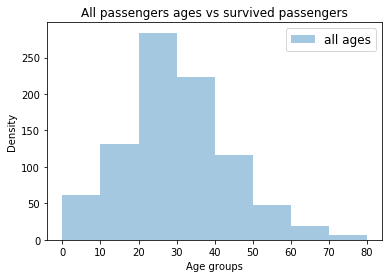

In [64]:
#plot again and see how the distribution stays the same but with more values
plot_distr(train)

You will notice the distribution shape looks identical, except if you look at the y-axis you will see that it has grown taller and relatively equal (of course we may be increasing the rareness of the extreme values a bit more, this isn't perfect but it will tend to strengthen the average affect of the distribution, instead of exaggerating the outliers if we used 2*Std.

Next we will extract the cabin letters from the tickets, and see if there is any information we can gleam from this

In [65]:
def cabin_letter(df):
    df['Cabin_letter'] = df['Cabin'].str.replace('\d+', '')
    df['Cabin_letter'] = df['Cabin_letter'].str[0:1]
    m = df['Cabin_letter'].value_counts().idxmax()
    df.loc[df['Cabin_letter'] == 'T', 'Cabin_letter'] = m
cabin_letter(train)
cabin_letter(test)

In [66]:
#add is_young category
train['is_young'] = np.where(train['Age'] < 11, 1, 0)
test['is_young'] = np.where(test['Age'] < 11, 1, 0)
#categorize family numbers
for letter in train['Embarked'].value_counts().index:
    train['embarked_' + letter] = np.where(train['Embarked']== letter, 1, 0)
    test['embarked_' + letter] = np.where(test['Embarked']== letter, 1, 0)


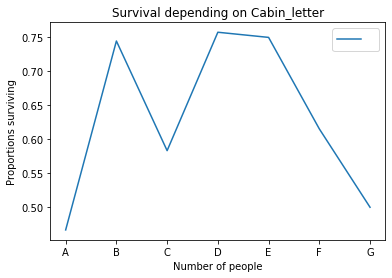

In [67]:
def plot_surv_category(d, cat):
    prop_survived_parch = d[cat][d['Survived'] == 1].value_counts().sort_index()/d[cat].value_counts().sort_index()
    prop_survived_parch = prop_survived_parch.fillna(0)
    df = pd.DataFrame({'proportion survived': prop_survived_parch,
                         'count': train[cat].value_counts().sort_index().index})


    sns.lineplot(x = 'count', y = 'proportion survived',  data=df, label=' ')
    #sns.distplot(,  kde=False,label='SibSp')
    #plt.ylim(0, 300)

    plt.legend(prop={'size': 12})
    #plt.title('All passengers ages vs survived passengers')
    plt.xlabel('Number of people')

    plt.ylabel('Proportions surviving')
    plt.title('Survival depending on ' + cat)
plot_surv_category(train, 'Cabin_letter')


Here can see there might be some importance to thos eparticularly cabin numbers, maybe they are easier to escape from, or maybe some of them are richer people too. Either way, we might extract a few of these important cabin numbers and use them as predictors

In [68]:
for letter in ['B', 'D', 'E']:
    train['cabin_' + letter] = np.where(train['Cabin_letter'] == letter, 1, 0)
    test['cabin_' + letter] = np.where(test['Cabin_letter'] == letter, 1, 0)


In [69]:
common = train['Embarked'].describe().top
train['Embarked'] = train['Embarked'].fillna(common)
common = test['Embarked'].describe().top
test['Embarked'] = test['Embarked'].fillna(common)

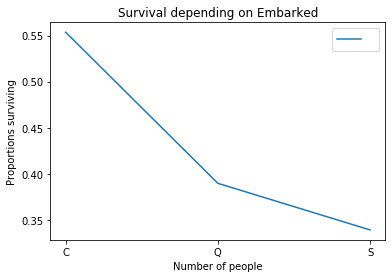

In [70]:
plot_surv_category(train, 'Embarked')

Also looking at the embark code, we see some differences in survival, again this might be very well related to class or cabin number, but maybe the ship was filled from the bottom up, so later boarding regions had an advantage? So we can add it to our list and see what it does.

In [71]:


def set_title_field(df):
    titles = {"Mr": 1, "Miss": 2, 'Mlle':2, 'Ms':2, 'Mme':3, "Mrs": 3, "Master": 4, "Rare": 5, 'Lady': 5, 'Countess':5 ,'Capt': 5, 'Col': 5,'Don': 5, 'Dr': 5,\
                                            'Major': 5, 'Rev': 5, 'Sir': 5, 'Jonkheer': 5, 'Dona': 5}

    df['title'] = 0
    
    title_set = set(titles.keys())
    l = list()
    for i in range(len(df)):
        vals = df['Name'].iloc[i].split(' ') 
        for j in vals:
            title = j.strip('.')
            if title in title_set:
                #print(title)
                df['title'].iloc[i] = titles[title]
                break
            
set_title_field(train)
set_title_field(test)
train['title'].value_counts()  

C:\Users\corma\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1    517
2    185
3    126
4     40
5     23
Name: title, dtype: int64

I am also seen form other peoples analysis of this data set the use of 'title', so I have extracted that and will use it.
I looked at how that was done here: https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8



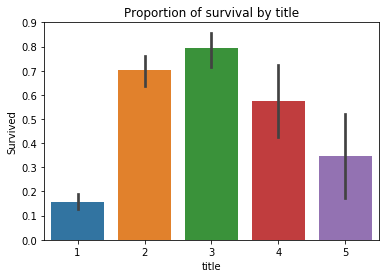

In [72]:
ax = sns.barplot(x="title", y="Survived", data=train);
plt.title('Proportion of survival by title');

In [73]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Cabin_letter,is_young,embarked_S,embarked_C,embarked_Q,cabin_B,cabin_D,cabin_E,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,S,NaN,0,1,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,C,C,0,0,1,0,0,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,S,NaN,0,1,0,0,0,0,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,S,C,0,1,0,0,0,0,0,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,S,NaN,0,1,0,0,0,0,0,1


So now we can see some of the new fields I have created for the categories, to allow the logistical model to intepret them

In [74]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Get variables for which to compute VIF and add intercept term 
#Pclass == 1 and Sex == male are the reference factors for those categories - it is redundant to put them in and actually causes errors

factors_arr = ['Age', 'embarked_C' , 'Parch', 'SibSp', 'Fare', 'cabin_B', 'cabin_D', 'cabin_E', 'title']



X = train[factors_arr].copy()
X['class 2'] = np.where(train['Pclass']== 2, 1, 0)
X['class 3'] = np.where(train['Pclass']== 3, 1, 0)
X['F'] = np.where(train['Sex']== 'female', 1, 0)
X['Intercept'] = 1 

factors_arr.append('Pclass')
factors_arr.append('Sex')

# Compute and view VIF 
vif = pd.DataFrame() 
vif["variables"] = X.columns 

vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 

  

# View results using print 

print(vif) 

     variables        VIF
0          Age   1.202685
1   embarked_C   1.142167
2        Parch   1.358218
3        SibSp   1.337804
4         Fare   1.873119
5      cabin_B   1.355742
6      cabin_D   1.186184
7      cabin_E   1.145892
8        title   1.532727
9      class 2   2.506703
10     class 3   3.499527
11           F   1.402502
12   Intercept  27.883492


Calculating the VIF we don't see anything except class 3 over the 2.5 threshold, so that looks pretty good. Although I will still take this with a grain of salt, given VIF's use with categorical is not as strong.

Next we will look at the model summary for all our new variables

In [89]:
data_slice = np.random.choice(len(train), replace=False, size=int(len(train)*0.6))
train_half = train[train.index.isin(data_slice)].copy()
train_2nd_half = train[~train.index.isin(data_slice)].copy()

#get optimal threshold 
formula = 'Survived ~ Age + SibSp + Parch + C(Pclass) + C(Sex) + embarked_C + cabin_B + cabin_D + cabin_E + C(title)'# + C(Cabin_letter)' 
model = glm(formula, data = train_half, family = sm.families.Binomial()).fit() 
print(model.summary()) 


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  534
Model:                            GLM   Df Residuals:                      519
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.90
Date:                Tue, 19 May 2020   Deviance:                       417.81
Time:                        10:35:40   Pearson chi2:                     530.
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         21.5465   1.23e+04      0.

We can see that title has a very high p-value, so we will remove this and refit the model.

In [91]:
formula = 'Survived ~ Age + SibSp + Parch + C(Pclass) + C(Sex) + embarked_C + cabin_B + cabin_D + cabin_E'# + C(Cabin_letter)' 
model = glm(formula, data = train_half, family = sm.families.Binomial()).fit() 
print(model.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  534
Model:                            GLM   Df Residuals:                      523
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -226.38
Date:                Tue, 19 May 2020   Deviance:                       452.76
Time:                        10:36:52   Pearson chi2:                     514.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.2239      0.589      7.

Next is Parch, which I thought was a nice DV from our previous model, but likely has some interactions with other variables.

In [92]:
formula = 'Survived ~ Age + SibSp + C(Pclass) + C(Sex) + embarked_C + cabin_B + cabin_D + cabin_E'# + C(Cabin_letter)' 
model = glm(formula, data = train_half, family = sm.families.Binomial()).fit() 
print(model.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  534
Model:                            GLM   Df Residuals:                      524
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -226.46
Date:                Tue, 19 May 2020   Deviance:                       452.92
Time:                        10:38:45   Pearson chi2:                     514.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.2612      0.581      7.

And again Embarked_C is also still remaining high so let's remove that.

In [96]:
formula = 'Survived ~ Age + SibSp + C(Pclass) + C(Sex) + cabin_B + cabin_D + cabin_E'# + C(Cabin_letter)' 
model = glm(formula, data = train_half, family = sm.families.Binomial()).fit() 
print(model.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  534
Model:                            GLM   Df Residuals:                      525
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -226.69
Date:                Tue, 19 May 2020   Deviance:                       453.38
Time:                        10:40:51   Pearson chi2:                     513.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.3573      0.565      7.

And finally Cabin_D

In [99]:
formula = 'Survived ~ Age + SibSp + C(Pclass) + C(Sex) + cabin_B + cabin_E'# + C(Cabin_letter)' 
model = glm(formula, data = train_half, family = sm.families.Binomial()).fit() 
print(model.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  534
Model:                            GLM   Df Residuals:                      526
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -227.14
Date:                Tue, 19 May 2020   Deviance:                       454.28
Time:                        10:41:48   Pearson chi2:                     513.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.5021      0.548      8.

Ok, so in our model these are looking pretty good now, we will accept these levels of p-value. In addtion looking at the coefficients, we can see things that make sense from our previous exploration.

Such as, reduced rate given lower class, male, and increasing age. While the cabin position seems to have a positive influence for us.

We will again arbitrarily use 60% of the data to train the model. I did mess around with training size with varying proportions and their corresponding accuracies. However this is difficult, because as you increase the train size, you reduce the test size, and then can't get an accurate view on how it predicts.

In [100]:
#find optimized threshold for model
def get_optimal_threshold(pred, df2):
    n = 40 
    thresholds = list()
    prop_corr = list()
    #print(len(df2))
    for i in np.linspace(0.0, 1, n):
        predicted_survive = (pred >= i)
        num_correct = (predicted_survive.astype(bool)) == (df2['Survived'].astype(bool))
        s = pd.DataFrame({'pred': predicted_survive,
                      'surv': df2['Survived'],
                         'AND': num_correct})
        #print(s[0:20])
        #break
        #l.append([i, sum(num_correct)])
        thresholds.append(i)
        prop_corr.append(sum(num_correct))

    df = pd.DataFrame({'threshold': thresholds, 'proportion correct':prop_corr})
    m = df['proportion correct'].idxmax()
    pr = df['threshold'].iloc[m]   
    #print('Best threshold: {:04.2f}\n'.format(pr) + 'Predictions correct: {}/{} == {:04.2f}'.format(df['proportion correct'].max(), len(df2), df['proportion correct'].max()/ len(df2)))
    return (pr, df['proportion correct'].max()/ len(df2))

#run model on random sampling and get best ratios
thresholds = list()
prediction_proportions = list()
for i in range(100):
    #randomly get 60% of data set values, use other 40% for testing
    #print('Using {} rows of data set to train'.format(int(len(train)*0.6)))
    data_slice = np.random.choice(len(train), replace=False, size=int(len(train)*0.6))
    train_half = train[train.index.isin(data_slice)].copy()
    train_2nd_half = train[~train.index.isin(data_slice)].copy()

    #using our final model
    pred_glm = model.predict(train_2nd_half) 
    thr_and_predRatio = get_optimal_threshold(pred_glm, train_2nd_half)
    thresholds.append(thr_and_predRatio[0])
    prediction_proportions.append(thr_and_predRatio[1])
    
AVG_THRESH = np.mean(thresholds)
print('Average threshold {}'.format(AVG_THRESH))
print('Mean pred {}'.format(np.mean(prediction_proportions)))
 

Average threshold 0.561025641025641
Mean pred 0.8138935574229693
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  534
Model:                            GLM   Df Residuals:                      526
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -227.14
Date:                Tue, 19 May 2020   Deviance:                       454.28
Time:                        10:44:20   Pearson chi2:                     513.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

We will pick our final model given our average threshold, and we have printed the mean prediction just to see how our model fared overall.

In [ ]:
# ----------------------------------------------------------------------------------------------------
# Trial at running model with variations of testing data sizes, made things overly complex for now
# Just leaving this code here incase I want it again
# ---------------------------------------------------------------------------------------------------


# Define model formula 

testing = False
if testing:
    
    data_split_ranges = np.linspace(int(len(train)/2), int(len(train)-50), 30, dtype = int)

    rows_list = []

    list_glms = list()
    l = list()
    for i in data_split_ranges:

        #get random rows
        data_slice = np.random.choice(len(train), replace=False, size=i)
        train_half = train[train.index.isin(data_slice)].copy()
        train_2nd_half = train[~train.index.isin(data_slice)].copy()

        formula = 'Survived ~ is_young + SibSp + Parch + C(Pclass) + C(Sex) + embarked_C + cabin_B + cabin_D + cabin_E + C(title)' # + C(Cabin_letter)' 
        model = glm(formula, data = train_half, family = sm.families.Binomial()).fit() 
        #print(model.summary()) 
        pred_glm = model.predict(train_2nd_half) 
        #list_glms.append(pred_glm)
        #train_2nd_half['expected_survive'] = pred_glm
        train_prop = i/len(train)*100 
        print('Testing data with {:02.2f}% of data set'.format(train_prop))
        thr_and_predRatio = get_optimal_threshold(pred_glm, train_2nd_half)
        row = {'train_data_proportion':  train_prop, 'optimal_threshold': thr_and_predRatio[0], 'prediction_proportion': thr_and_predRatio[1]}
        rows_list.append(row)
        print('----------------------')


    df_opt = pd.DataFrame(rows_list)


 

In [101]:
#train model with our prefered options
data_slice = np.random.choice(len(train), replace=False, size=int(len(train)*0.6))
train_half = train[train.index.isin(data_slice)].copy()
train_2nd_half = train[~train.index.isin(data_slice)].copy()

#Use previous model using test data and avg threshold
pred_glm = model.predict(test) 
predicted_survive = (pred_glm >= AVG_THRESH)
test['Survived'] = predicted_survive.astype(int)
test_file = test[['PassengerId', 'Survived']]
test_file.to_csv('submission_2.csv', header=True, index=False)


In [102]:
#Submit to kaggle

import subprocess
query = 'kaggle competitions submit -c titanic -f submission_2.csv -m "Glm"'.split(' ')

try:
    print('Sending predictions')
    subprocess.check_output(query)
except:
    print('failed')

print('Query finished')

Sending predictions
Query finished


After finally submitting our responses, we got '0.77511' accuracy. This isn't even as good as our original model, nd if we removed any more variables we would approach that same model anyway. So in this case of GLM, our simple model seems the most appropriate. 